# Transcript to silence vector

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from glob import glob
import os
from matplotlib.pylab import *
import librosa
import torch
from epoch_time import epoch_time
from tqdm.notebook import tqdm
from OpenASR_convert_reference_transcript import txt_to_stm
import pandas as pd
import numpy as np
from padarray import padarray
from to_samples import to_samples
from torch.utils.data import TensorDataset, DataLoader
import audioread
import random
import soundfile as sf

In [4]:
stage='NIST'
sample_rate=8000
window = sample_rate
H=window

In [5]:
transcripts = list(sorted(glob(f'{stage}/*/build/transcription/*.txt')))
len(transcripts)

122

In [6]:
audio_files=[x.replace('/transcription/', '/audio/').replace('.txt','.wav') for x in transcripts]

In [7]:
X_samples=[]
Y_samples=[]

In [8]:
for transcript_file in tqdm(transcripts):
    audio_file = transcript_file.replace('/transcription/', '/audio/').replace('.txt','.wav')
    if not os.path.exists(audio_file):
        print('missing', audio_file)
        continue
    file = "_".join(os.path.basename(transcript_file).split("_")[:-1])
    channel = os.path.basename(transcript_file).split("_")[-1].split(".")[-2]
    transcript_df = pd.read_csv(transcript_file, sep = "\n", header = None, names = ["content"])
    result = txt_to_stm(transcript_df, file, channel)
    silences=[(float(x[-2]), float(x[-1])) for x in result if len(x)==5]
    x_np,sr=librosa.load(audio_file, sr=sample_rate)
    with audioread.audio_open(audio_file) as f:
        sr = f.samplerate
    if sr != sample_rate:
        print('RESIZING', sr, audio_file)
        sf.write(audio_file, x_np, sample_rate)
    recording_length=x_np.shape[0]
    silence_segments=[(int(a*sample_rate), int(b*sample_rate)) for (a,b) in silences]
    y_np=np.zeros(recording_length,dtype=x_np.dtype)
    for lower, upper in silence_segments:
        y_np[lower:upper]=1
    pad_length=(x_np.size + (H-(x_np.size % H)))
    x_samples_np=to_samples(x_np, window, 600)
    y_samples_np=to_samples(y_np, window, 600)
    X_samples.extend(x_samples_np)
    Y_samples.extend(y_samples_np)

In [9]:
len(Y_samples)

73194

In [10]:
len(list(zip(X_samples, Y_samples)))

73194

In [11]:
XY_samples=[(x,y) for x,y in zip(X_samples, Y_samples)]
random.shuffle(XY_samples)

In [12]:
X_samples = [x for x,y in XY_samples]
Y_samples = [y for x,y in XY_samples]
len(X_samples)

73194

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
fudge=100000

In [15]:
tensor_x = torch.Tensor(X_samples[0:fudge]).to(device)

In [16]:
tensor_y = torch.Tensor(Y_samples[0:fudge]).to(device)

In [17]:
full_dataset = TensorDataset(tensor_x,tensor_y) 

In [18]:
tensor_y.shape

torch.Size([73194, 8000])

In [19]:
D_in,D_out=window,window
D_in,H,D_out

(8000, 8000, 8000)

In [20]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU()
).cuda()

In [21]:
model_fn='silence_detector.pt'
if 1:
    model.load_state_dict(torch.load(model_fn))
else:
    w1_np = np.random.randn(D_in, H)
    w2_np = np.random.randn(H, D_out)
    w1 = torch.randn((D_in, H), device=device, dtype=dtype)
    w2 = torch.randn((H, D_out), device=device, dtype=dtype)

In [22]:
best_loss = float('inf')
learning_rate =.0001
criterion = torch.nn.MSELoss(reduction='sum')

In [23]:
def trainer(device, model, iterator, optimizer, criterion, clip=1):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        x=batch[0]
        y=batch[1]
        optimizer.zero_grad()
        y_pred=model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [24]:
def evaluator(device, model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            x=batch[0]
            y=batch[1]
            y_pred=model(x)
            loss = criterion(y_pred, y)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [25]:
best_valid_loss = float('inf')

In [26]:
learning_rate=0.00002

In [27]:
epochs=10000
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [28]:
error_nn=[]
n_passes_not_saved = 0

for epoch in range(epochs):

    start_time = time.time()
    
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    train_iterator = torch.utils.data.DataLoader(train_dataset, 
                                                 batch_size=128, shuffle=False, num_workers=0)
    valid_iterator = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=128, shuffle=False, num_workers=0)
    
    start_time = time.time()
    
    train_loss = trainer(device, model, train_iterator, optimizer, criterion)
    valid_loss = evaluator(device, model, valid_iterator, criterion)
    error_nn.append(train_loss)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s Train Loss: {train_loss:.3f} Val. Loss: {valid_loss:.3f}')
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_fn)
        print('saved', model_fn)
        print()
        n_passes_not_saved = 0
    else:
        n_passes_not_saved += 1
    
    if n_passes_not_saved > 50:
        for g in optimizer.param_groups:
            g['lr'] *= 0.998
        print(f"learning rate is now {g['lr']:.8f}")
        n_passes_not_saved = 0

Epoch: 01 | Time: 0m 16s Train Loss: 137514.291 Val. Loss: 137327.232
saved silence_detector.pt

Epoch: 02 | Time: 0m 16s Train Loss: 119823.062 Val. Loss: 117262.320
saved silence_detector.pt

Epoch: 03 | Time: 0m 16s Train Loss: 113188.154 Val. Loss: 109194.153
saved silence_detector.pt

Epoch: 04 | Time: 0m 16s Train Loss: 109251.670 Val. Loss: 105593.346
saved silence_detector.pt

Epoch: 05 | Time: 0m 16s Train Loss: 106310.432 Val. Loss: 104586.261
saved silence_detector.pt

Epoch: 06 | Time: 0m 16s Train Loss: 104178.904 Val. Loss: 103161.118
saved silence_detector.pt

Epoch: 07 | Time: 0m 16s Train Loss: 102574.435 Val. Loss: 101129.233
saved silence_detector.pt

Epoch: 08 | Time: 0m 16s Train Loss: 100894.892 Val. Loss: 100034.608
saved silence_detector.pt

Epoch: 09 | Time: 0m 16s Train Loss: 99604.185 Val. Loss: 98198.332
saved silence_detector.pt

Epoch: 10 | Time: 0m 16s Train Loss: 98279.587 Val. Loss: 96855.700
saved silence_detector.pt

Epoch: 11 | Time: 0m 17s Train Los

Epoch: 109 | Time: 0m 16s Train Loss: 69881.173 Val. Loss: 69816.685
Epoch: 110 | Time: 0m 16s Train Loss: 69719.382 Val. Loss: 69618.190
Epoch: 111 | Time: 0m 16s Train Loss: 69675.542 Val. Loss: 69907.061
Epoch: 112 | Time: 0m 16s Train Loss: 69578.549 Val. Loss: 69754.138
Epoch: 113 | Time: 0m 16s Train Loss: 70038.253 Val. Loss: 67813.900
saved silence_detector.pt

Epoch: 114 | Time: 0m 16s Train Loss: 69706.309 Val. Loss: 69123.550
Epoch: 115 | Time: 0m 16s Train Loss: 69771.320 Val. Loss: 67792.239
saved silence_detector.pt

Epoch: 116 | Time: 0m 16s Train Loss: 69461.552 Val. Loss: 68979.210
Epoch: 117 | Time: 0m 16s Train Loss: 69460.363 Val. Loss: 69230.619
Epoch: 118 | Time: 0m 16s Train Loss: 68788.706 Val. Loss: 71498.116
Epoch: 119 | Time: 0m 16s Train Loss: 68773.596 Val. Loss: 71296.506
Epoch: 120 | Time: 0m 16s Train Loss: 69269.708 Val. Loss: 69082.192
Epoch: 121 | Time: 0m 16s Train Loss: 69202.962 Val. Loss: 69109.997
Epoch: 122 | Time: 0m 16s Train Loss: 69602.699 V

KeyboardInterrupt: 

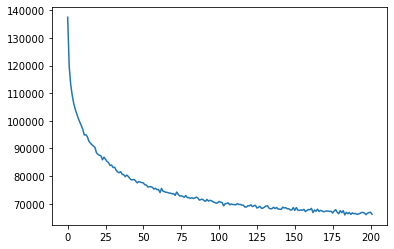

In [29]:
plot(error_nn)

In [30]:
torch.save(model.state_dict(), model_fn)